In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
ts = 'TIME_SERIES_DAILY'
symbol = 'TSLA'
#interval = '5min'
api_key = ''
outputsize = 'compact'

link = 'https://www.alphavantage.co/query?function={}&symbol={}&apikey={}&outputsize={}'\
        .format(ts, symbol, api_key, outputsize)

In [3]:
r = requests.get(link)
print(r.text)

{
    "Meta Data": {
        "1. Information": "Daily Prices (open, high, low, close) and Volumes",
        "2. Symbol": "TSLA",
        "3. Last Refreshed": "2019-10-25",
        "4. Output Size": "Compact",
        "5. Time Zone": "US/Eastern"
    },
    "Time Series (Daily)": {
        "2019-10-25": {
            "1. open": "297.7200",
            "2. high": "330.0000",
            "3. low": "296.1100",
            "4. close": "328.1300",
            "5. volume": "29409863"
        },
        "2019-10-24": {
            "1. open": "298.3700",
            "2. high": "304.9300",
            "3. low": "289.2000",
            "4. close": "299.6800",
            "5. volume": "29720900"
        },
        "2019-10-23": {
            "1. open": "254.5000",
            "2. high": "256.1400",
            "3. low": "251.3500",
            "4. close": "254.6800",
            "5. volume": "5261100"
        },
        "2019-10-22": {
            "1. open": "254.3200",
            "2. high": "258

In [4]:
data = json.loads(r.text)
stock_data_per_day = json.dumps(data["Time Series (Daily)"])
df = pd.read_json(stock_data_per_day).transpose()
df.reset_index(level=0, inplace=True)
df.columns = ['times', 'open', 'high', 'low', 'close', 'volume']
print(df.head())
print(len(df))

       times    open    high     low   close      volume
0 2019-10-25  297.72  330.00  296.11  328.13  29409863.0
1 2019-10-24  298.37  304.93  289.20  299.68  29720900.0
2 2019-10-23  254.50  256.14  251.35  254.68   5261100.0
3 2019-10-22  254.32  258.33  250.85  255.58   4600800.0
4 2019-10-21  258.33  259.50  250.18  253.50   5020300.0
100


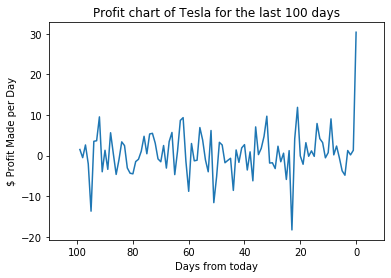

In [5]:
#Profit gains per day
profits = [ close_stock - open_stock for open_stock, close_stock in zip(df['open'], df['close'])]
plt.plot(df.index, profits)
plt.xlim(len(df.index)+10,0-10)
plt.xlabel('Days from today')
plt.ylabel('$ Profit Made per Day')
plt.title('Profit chart of Tesla for the last 100 days')
plt.show()